# Spotify Image Blender and Generator

## Import Tools

In [1]:
# General
import numpy as np
from numpy import argmax
import pandas as pd
from collections import Counter
from datetime import datetime
import itertools
import math
import collections

# Neural Network (Tensorflow)
import tensorflow as tf

# Warnings
import warnings 
warnings.filterwarnings("ignore")

2022-12-31 15:15:02.380095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from spotify_functions import *

## Create Spotipy object

In [3]:
load_dotenv()
SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
SPOTIFY_CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')
SPOTIFY_REDIRECT_URI = 'http://localhost:8080'
SCOPE = "playlist-modify-public playlist-read-collaborative playlist-modify-private user-top-read"

In [4]:
sp = authorize_user(SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET, SPOTIFY_REDIRECT_URI, SCOPE)

Authorization Sucessful!


## Extract top artists and album covers from current user

In [5]:
top_10_artist_names, top_10_uri = get_top_artists(sp, 10)

In [6]:
print(top_10_artist_names)

['The Weeknd', 'A$AP Rocky', 'Kanye West', 'Baby Keem', 'JID', 'Crush', 'Jay Park', 'HYNN', 'Adele', 'JAY-Z']


In [7]:
top_cover_art_links = get_top_cover_art(sp, top_10_uri, top_limit=1)

In [8]:
print(top_cover_art_links)

['https://i.scdn.co/image/ab67616d0000b27313e54d6687e65678d60466c2', 'https://i.scdn.co/image/ab67616d0000b2739feadc48ab0661e9b3a9170b', 'https://i.scdn.co/image/ab67616d0000b2731dacfbc31cc873d132958af9', 'https://i.scdn.co/image/ab67616d0000b273683757f1fd40a7f7ef64bec1', 'https://i.scdn.co/image/ab67616d0000b273fc915b69600dce2991a61f13', 'https://i.scdn.co/image/ab67616d0000b2737968a5fd0be134742699910e', 'https://i.scdn.co/image/ab67616d0000b2734b378770cd6b77e86f8a6288', 'https://i.scdn.co/image/ab67616d0000b273d2483c174efed828ae9768ae', 'https://i.scdn.co/image/ab67616d0000b273c6b577e4c4a6d326354a89f7', 'https://i.scdn.co/image/ab67616d0000b2734a767758e8ebe2443591c9fd']


## Tensorflow Artistic Style Tranfer

In [9]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

Search album names for cover art:

In [10]:
content_search = 'Starboy Weeknd'
style_search = 'Ology Gallant'

In [11]:
search1 = sp.search(content_search, limit=1, offset=0, type='album,artist', market=None)
search2 = sp.search(style_search, limit=1, offset=0, type='album', market=None)

In [12]:
album1_img_url = search1['albums']['items'][0]['images'][0]['url']
album1_name = search1['albums']['items'][0]['name']

album2_img_url = search2['albums']['items'][0]['images'][0]['url']
album2_name = search2['albums']['items'][0]['name']

In [13]:
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

In [14]:
content_image_name = album1_img_url.split('/')[-1]
content_path = tf.keras.utils.get_file(content_image_name, album1_img_url)

style_image_name = album2_img_url.split('/')[-1]
style_path = tf.keras.utils.get_file(style_image_name, album2_img_url)

In [15]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


2022-12-31 15:15:15.951171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


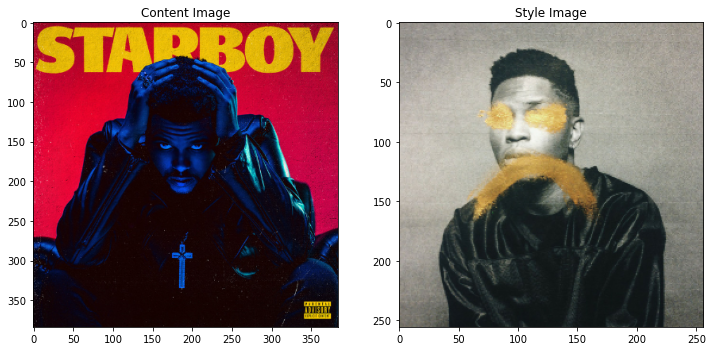

In [16]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

In [17]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


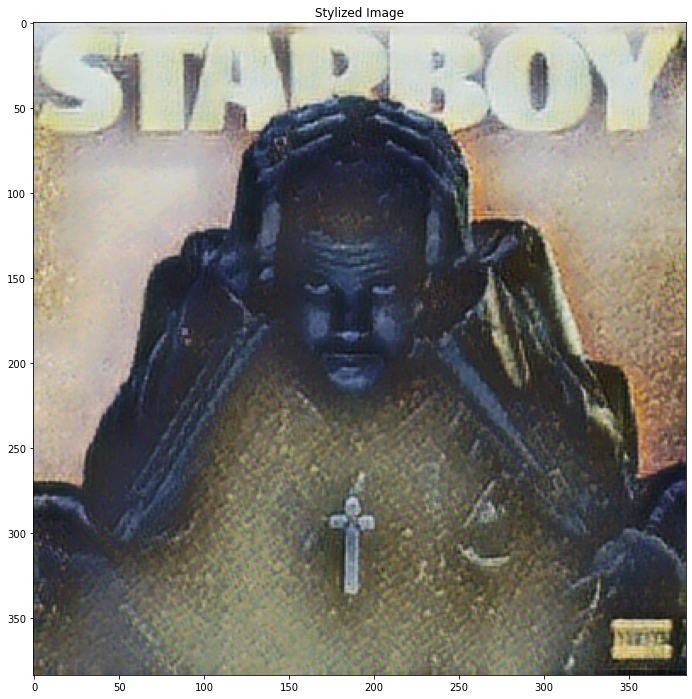

In [18]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

In [19]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

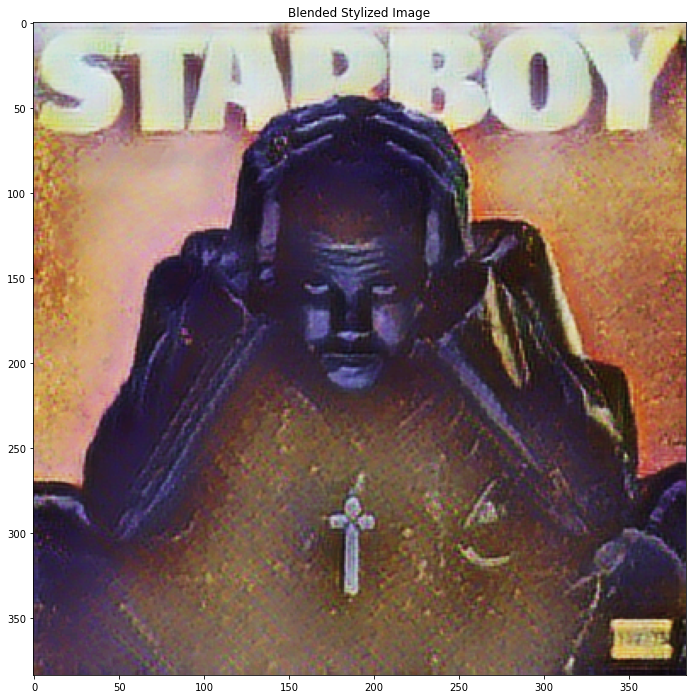

In [20]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.2

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

## Tensorflow Object Detection

In [21]:
# For running inference on the TF-Hub module
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time
import time

### Helper functions

In [22]:
def display_image(image):
  fig = plt.figure(figsize=(10, 10))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  det_object_list = []

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
      det_object = class_names[i].decode("ascii")
      det_object_list.append(det_object)
  return image, det_object_list

### Apply Module

In [23]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [24]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  print(result)

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes, det_object_list = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)
  return det_object_list

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 256, 256)
  det_object_list = run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)
  return det_object_list

Image downloaded to /var/folders/6m/88dwrhnx7m3cybxwl1p0rtq40000gn/T/tmpoituxlpy.jpg.


2022-12-31 15:17:23.614093: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 4 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 4194304 memory_size: 268435456 } outputs { dtype: DT_FLOAT shap

{'detection_class_entities': array([b'Person', b'Person', b'Clothing', b'Poster', b'Clothing', b'Man',
       b'Footwear', b'Human face', b'Picture frame', b'Human head',
       b'Man', b'Clothing', b'Human head', b'Person', b'Woman',
       b'Human face', b'Human body', b'Poster', b'Human face', b'Person',
       b'Person', b'Book', b'Human head', b'Person', b'Footwear',
       b'Human face', b'Human body', b'Person', b'Person', b'Human head',
       b'Mammal', b'Human face', b'Human hair', b'Man', b'Man',
       b'Human arm', b'Human face', b'Human head', b'Human face',
       b'Footwear', b'Human head', b'Human face', b'Clothing', b'Person',
       b'Clothing', b'Human hair', b'Human hair', b'Footwear',
       b'Clothing', b'Human arm', b'Footwear', b'Mammal', b'Tree',
       b'Human arm', b'Billboard', b'Human body', b'Person', b'Man',
       b'Human face', b'Human face', b'Clothing', b'Clothing',
       b'Human head', b'Poster', b'Human head', b'Clothing',
       b'Human hair', b'

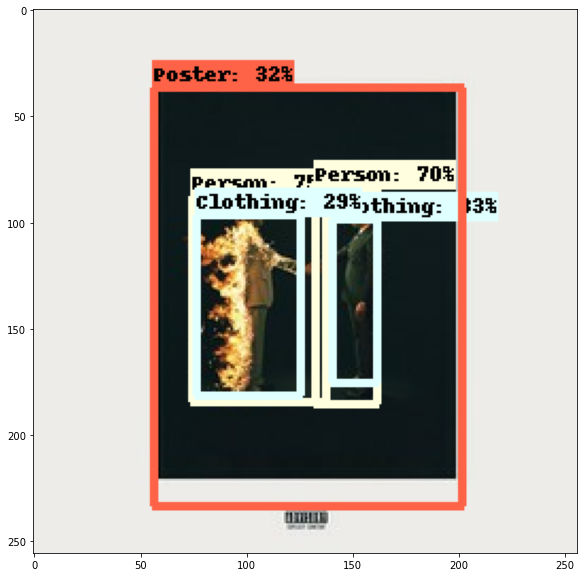

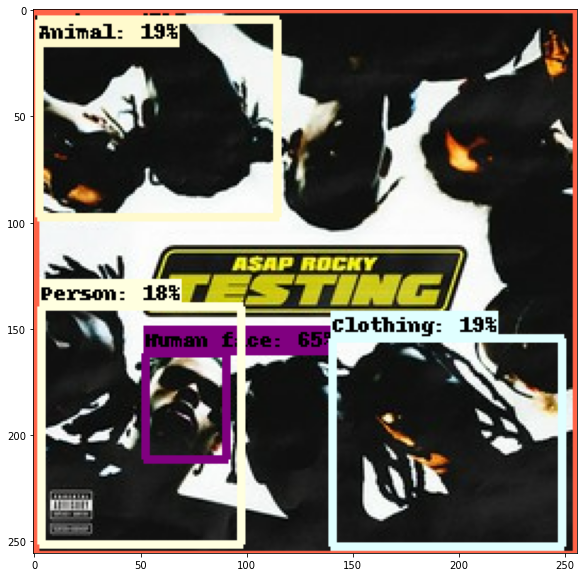

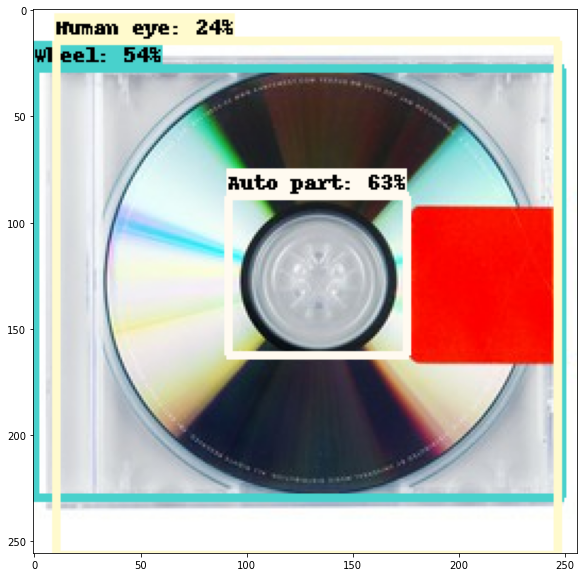

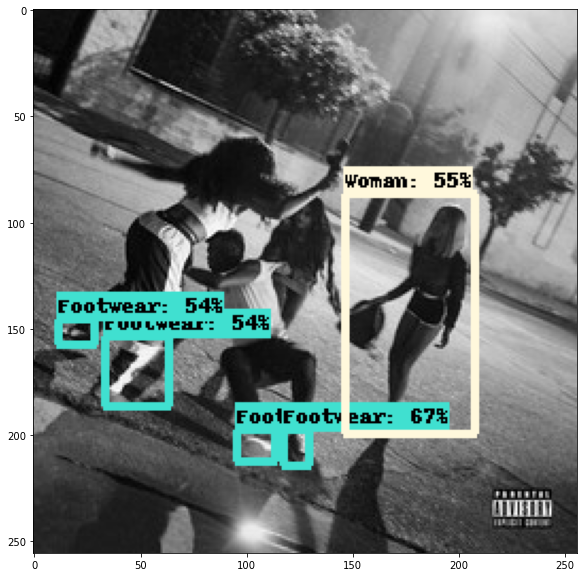

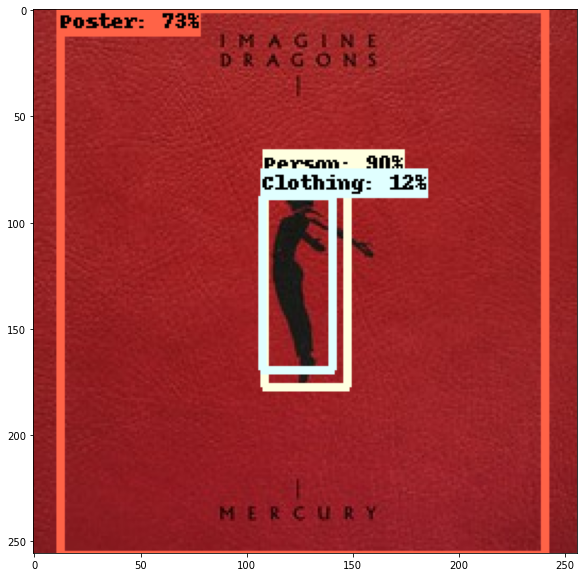

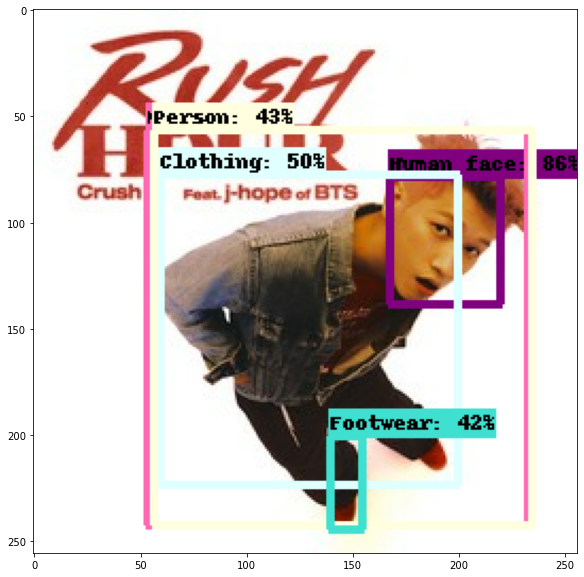

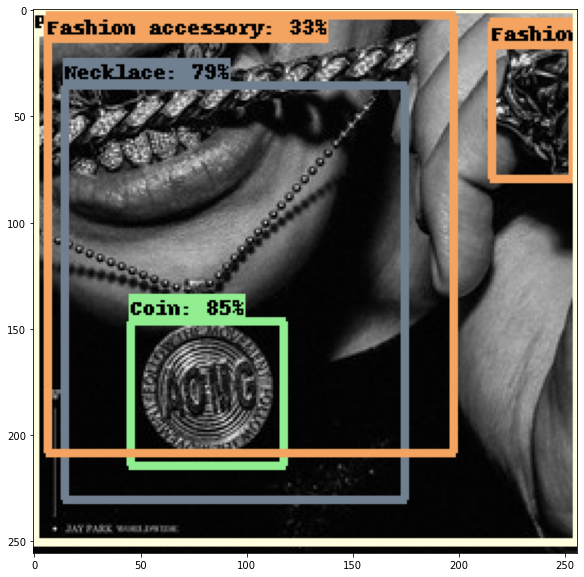

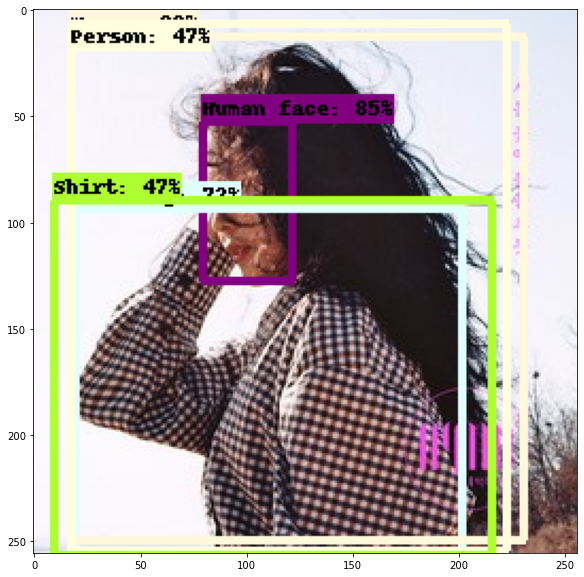

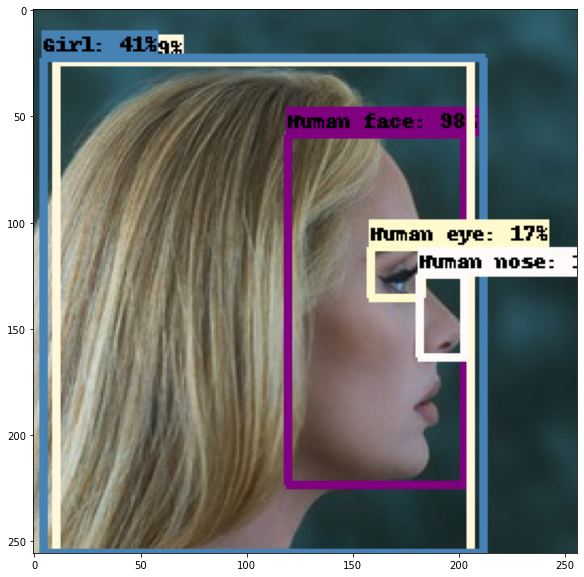

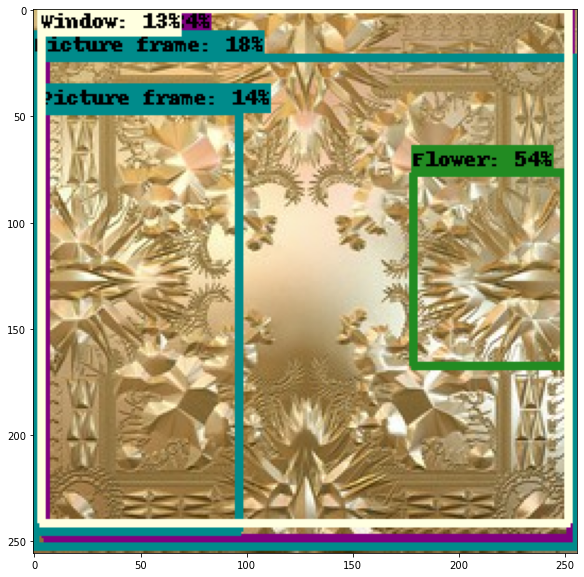

In [25]:
total_object_list = []

for i in range(len(top_cover_art_links)):
    det_object_list = detect_img(top_cover_art_links[i])
    total_object_list.extend(det_object_list)


In [26]:
print(total_object_list)

['Person', 'Person', 'Clothing', 'Poster', 'Clothing', 'Human face', 'Poster', 'Animal', 'Clothing', 'Person', 'Auto part', 'Wheel', 'Human eye', 'Footwear', 'Footwear', 'Woman', 'Footwear', 'Footwear', 'Person', 'Poster', 'Clothing', 'Human face', 'Man', 'Clothing', 'Person', 'Footwear', 'Coin', 'Necklace', 'Fashion accessory', 'Person', 'Fashion accessory', 'Human face', 'Clothing', 'Woman', 'Person', 'Shirt', 'Human face', 'Woman', 'Girl', 'Human eye', 'Human nose', 'Flower', 'Building', 'Picture frame', 'Picture frame', 'Window']


In [56]:
total_object_list = list(set(total_object_list))
prompt_begin = [''] # Can be adjusted to specify prompt
prompt_begin.extend(total_object_list)
print(prompt_begin)

['', 'Picture frame', 'Necklace', 'Footwear', 'Window', 'Human face', 'Shirt', 'Fashion accessory', 'Animal', 'Wheel', 'Coin', 'Girl', 'Person', 'Auto part', 'Man', 'Woman', 'Human nose', 'Poster', 'Clothing', 'Human eye', 'Flower', 'Building']


## OpenAI DALL-E 2

In [57]:
import openai
import PIL.Image

In [58]:
input_prompt = " ".join(prompt_begin)
print(input_prompt)

 Picture frame Necklace Footwear Window Human face Shirt Fashion accessory Animal Wheel Coin Girl Person Auto part Man Woman Human nose Poster Clothing Human eye Flower Building


In [59]:
load_dotenv()
openai.api_key = os.getenv('OPEN_AI_SECRET_KEY')

In [60]:
response = openai.Image.create(
  prompt=input_prompt,
  n=1,
  size="512x512"
)
image_url = response['data'][0]['url']

787387/787387 [==============================] - 0s 0us/step


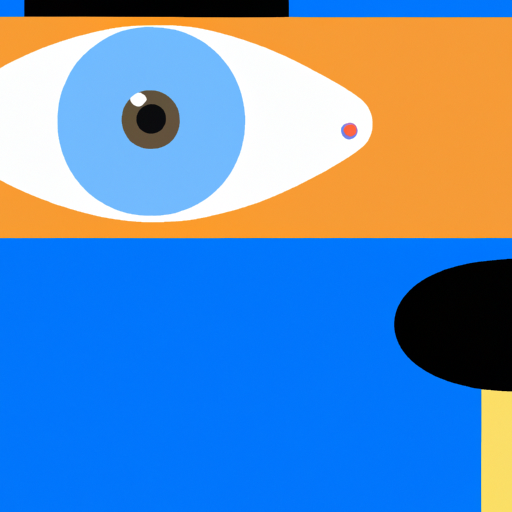

In [61]:
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


original_img = download(image_url, max_dim=512)
show(original_img)

Search for an album to apply style with:

In [62]:
style_album = 'Anthology Grover Washington'

In [63]:
search = sp.search(style_album, limit=1, offset=0, type='album,artist', market=None)

In [64]:
style_album_img_url = search['albums']['items'][0]['images'][0]['url']
style_album_name = search['albums']['items'][0]['name']

content_image_name = image_url.split('/')[-1]
content_path = tf.keras.utils.get_file(content_image_name, image_url)

style_image_name = style_album_img_url.split('/')[-1]
style_path = tf.keras.utils.get_file(style_image_name, style_album_img_url)

In [65]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

In [66]:
# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


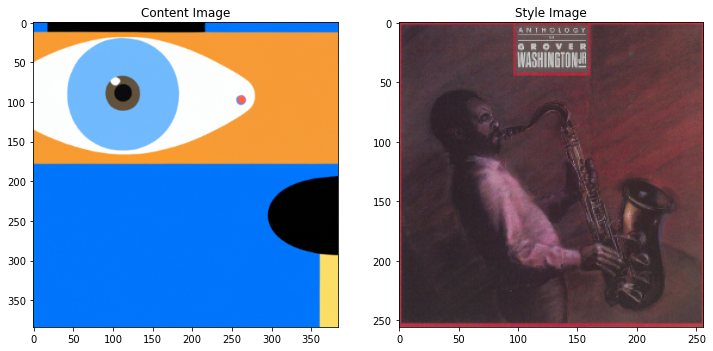

In [67]:
plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

In [68]:
# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


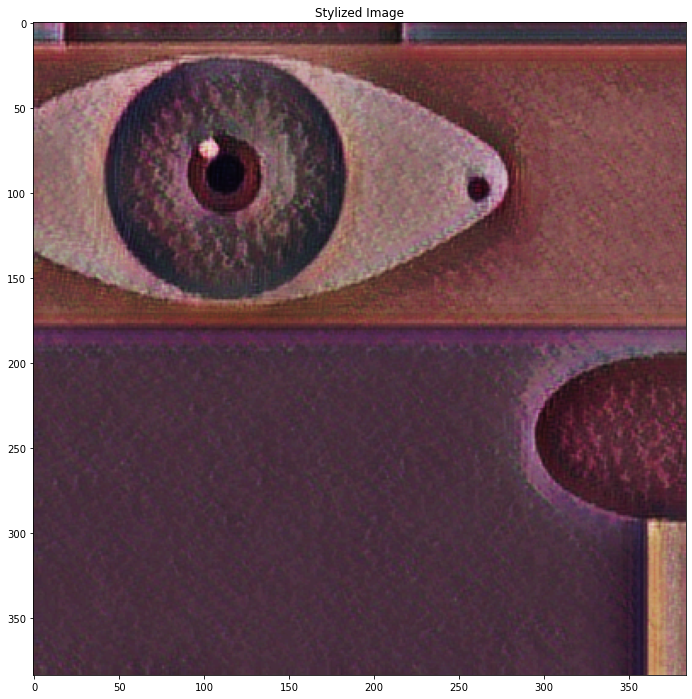

In [69]:
# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

In [70]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

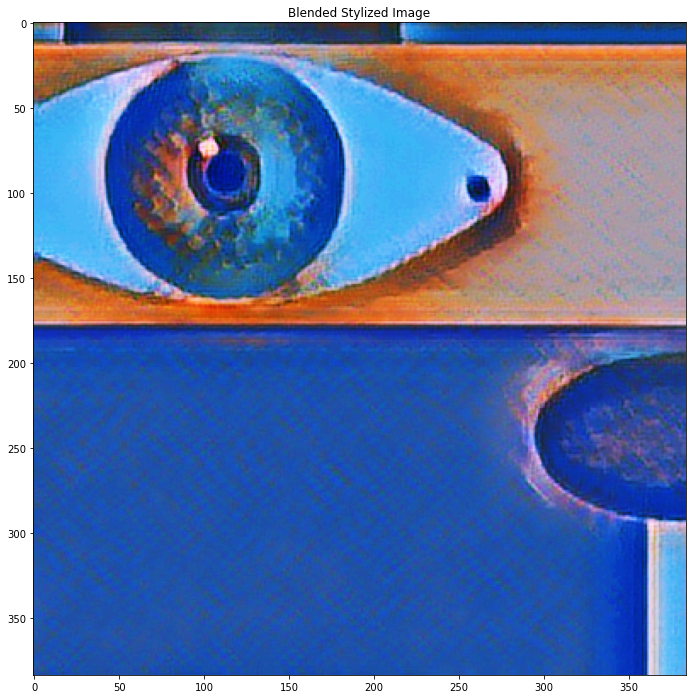

In [71]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.5

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')